In [8]:
# Importing standard Qiskit libraries 
from qiskit import *
# from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')


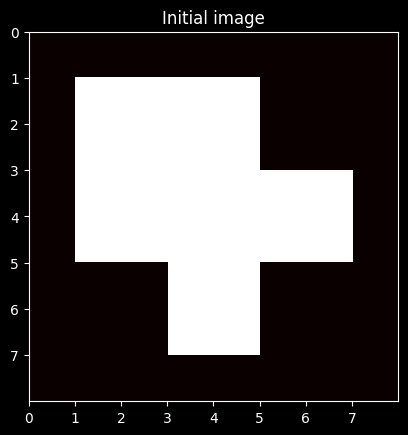

In [9]:
# representing a binary image(8x8) in form of a numpy array

img = np.array([  [0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 0, 0, 0],
                  [0, 1, 1, 1, 1, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 0, 0, 0],
                  [0, 0, 0, 1, 1, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0] ])


# plot image function

def plot_image(Image, title):
    plt.title(title)
    plt.xticks(range(Image.shape[0]))
    plt.yticks(range(Image.shape[1]))
    plt.imshow(Image, extent=[  0,Image.shape[0], Image.shape[1],0,], cmap='hot')
    plt.show()
    
plot_image(img, 'Initial image')

In [10]:
#we encode the intensities of image pixels as probability amplitudes of quantum states
#we use normalization for this
#we normalize the amplitudes to lie in the range (0,1)

# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)


#we now normalize image and get coefficients in both horizontal and vertical directions

# Horizontal: Original image
h_norm_image = amplitude_encode(img)
print("Horizontal image normalized coefficients",h_norm_image)


print()
print()

# Vertical: Transpose of Original image
v_norm_image = amplitude_encode(img.T)
print("vertical image normalized coefficients",v_norm_image)

print()
print("size of 1d array",h_norm_image.shape)
print("size of 1d array",v_norm_image.shape)

Horizontal image normalized coefficients [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.20412415 0.20412415 0.20412415
 0.20412415 0.         0.         0.         0.         0.20412415
 0.20412415 0.20412415 0.20412415 0.         0.         0.
 0.         0.20412415 0.20412415 0.20412415 0.20412415 0.20412415
 0.20412415 0.         0.         0.20412415 0.20412415 0.20412415
 0.20412415 0.20412415 0.20412415 0.         0.         0.
 0.         0.20412415 0.20412415 0.         0.         0.
 0.         0.         0.         0.20412415 0.20412415 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


vertical image normalized coefficients [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.20412415 0.20412415 0.20412415
 0.20412415 0.         0.         0.         0.         0.20412415
 0.20412415 0.20412415 0.20412415 0.         0.         0

In [11]:
#we require N=log(8*8) qubits 
#N=6

data_q = 6
ancillary_q = 1
total_q = data_q + ancillary_q

# Initialize the amplitude permutation unitary
Amp_permutation_unitary = np.identity(2**total_q)
print(Amp_permutation_unitary)
Amp_permutation_unitary=np.roll(Amp_permutation_unitary,1,axis=1)
print()
print()
print()
print("shift Amplitude permutation matrix by 1 unit to the right column wise")
print()
print(Amp_permutation_unitary)
print()
print("we will later use this for while applying hadamard operation to image coefficient vectors")
print()
print(Amp_permutation_unitary.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]



shift Amplitude permutation matrix by 1 unit to the right column wise

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]]

we will later use this for while applying hadamard operation to image coefficient vectors

(128, 128)


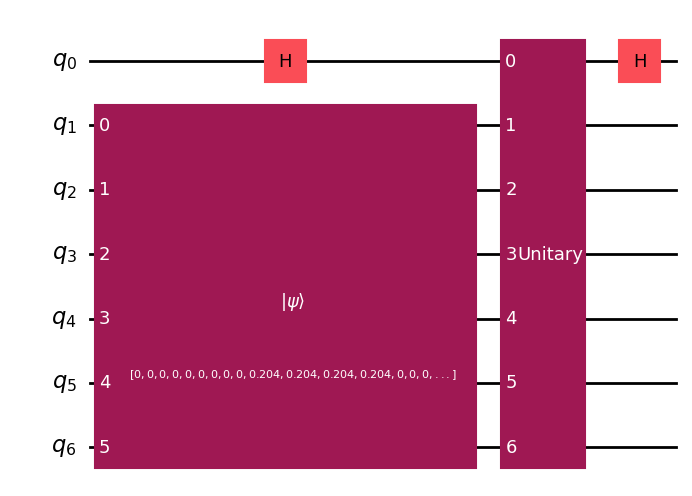

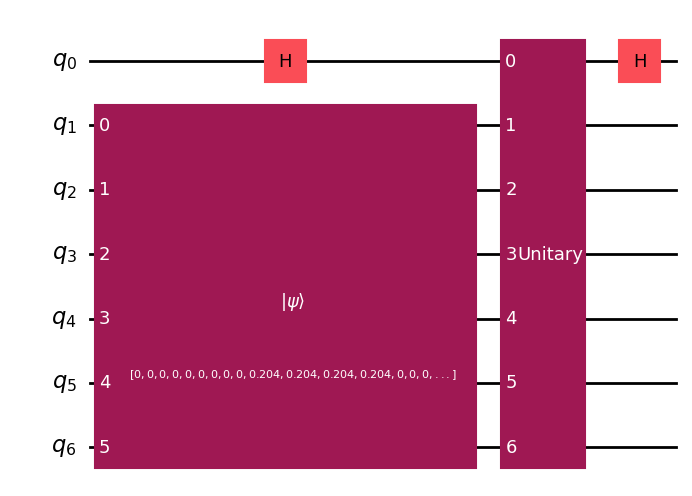

In [12]:
# Creating the circuit for horizontal scan

qc_h = QuantumCircuit(total_q)
qc_h.initialize(h_norm_image, range(1, total_q))
qc_h.h(0)
qc_h.unitary(Amp_permutation_unitary, range(total_q))
qc_h.h(0)

display(qc_h.draw('mpl', fold=-1))


# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_q)
qc_v.initialize(v_norm_image, range(1, total_q))
qc_v.h(0)
qc_v.unitary(Amp_permutation_unitary, range(total_q))
qc_v.h(0)

display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [ ]:
from qiskit import transpile
from qiskit_aer import AerSimulator

# Simulate the circuit using AerSimulator
simulator = AerSimulator()
tqc = transpile(circ_list, simulator)
results = simulator.run(tqc).result()
state_vector_h = results.get_statevector(qc_h)
state_vector_v = results.get_statevector(qc_v)


In [26]:
from qiskit import transpile, QuantumCircuit
from qiskit_aer import Aer
from qiskit.visualization import array_to_latex
from IPython.display import display

# Assuming circ_list contains your list of QuantumCircuits
# and qc_h and qc_v are your specific circuits for horizontal and vertical scans

# Use a simulator to execute the quantum circuits
backend = Aer.get_backend('statevector_simulator')

# Transpile the circuits for the simulator
tqc_list = [transpile(circ, backend) for circ in circ_list]

# Run the simulations
results = backend.run(tqc_list).result()

# Get the state vectors for each circuit
state_vector_h = results.get_statevector(circ_list[0])  # Assuming qc_h is the first in circ_list
state_vector_v = results.get_statevector(circ_list[1])  # Assuming qc_v is the second in circ_list

# Print the size of the state vectors
print("State vector size:", state_vector_h.size)

# Display the state vectors in LaTeX format
print('Horizontal scan statevector:')
display(array_to_latex(state_vector_h, max_size=128))
print()
print('Vertical scan statevector:')
display(array_to_latex(state_vector_v, max_size=128))


C:\Users\DELL\AppData\Local\Temp\ipykernel_10560\2469849290.py:23: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  print("State vector size:", state_vector_h.size)


State vector size: 128
Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

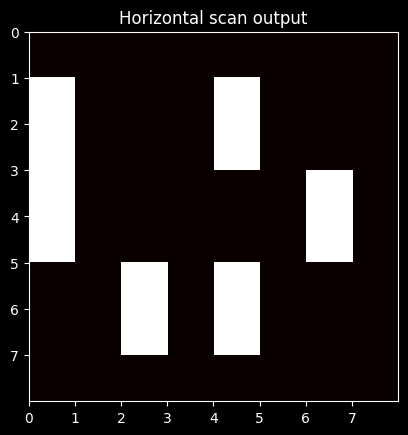

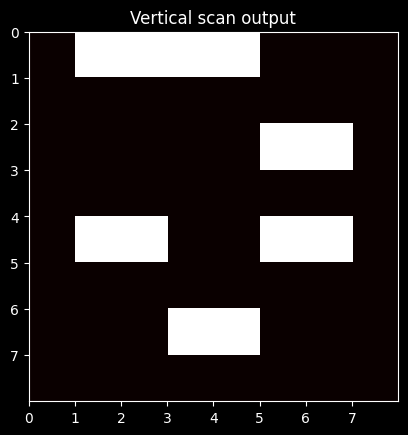

In [27]:
#  postprocessing for plotting the output (Classical)

# Defining a lambda function for thresholding to binary values
# returns true for specified Amplitude values else false
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
h_edge_scan_img = np.abs(np.array([1 if threshold(state_vector_h[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8)
v_edge_scan_img= np.abs(np.array([1 if threshold(state_vector_v[(2*i)+1].real) else 0 for i in range(2**data_q)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(h_edge_scan_img, 'Horizontal scan output')
plot_image(v_edge_scan_img, 'Vertical scan output')

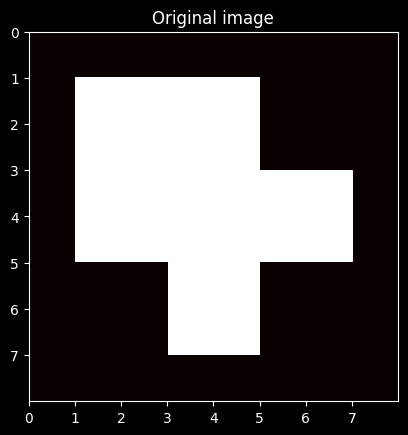

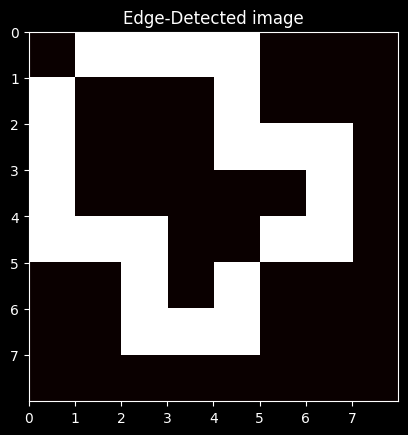

In [28]:
# Combining the horizontal and vertical component of the result by or operator
edge_scan_image = h_edge_scan_img | v_edge_scan_img

# Plotting the original and edge-detected images
plot_image(img, 'Original image')
plot_image(edge_scan_image, 'Edge-Detected image')